## Study of the score calibration used by HH-Suite

The neural network calibration used by default in HHsearch/HHblits/HHalign controls how hit score value is converted to the reported p-value, e-value, and probability for each search hit.
In HH-Suite v.2.x there is an option, "-calm" that can switch off this mode, whereas in HH-Suite v.3.x this option was deleted. See the [User Guide](https://github.com/soedinglab/hh-suite/wiki#dont-i-need-to-calibrate-my-query-or-database-hmm) for brief description of this feature.

In [2]:
import os
import sys
import math
import copy as cp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%pylab inline
print(numpy.__version__)
print(matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
1.16.2
3.0.3


These functions are adapted from HH-Suite 2.0.16 C++ code:

In [3]:
class Hit:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def CalculatePvalues(h):
    log1000 = math.log(1000.0)
    query_log_len = math.log(h.q_L)/log1000
    hit_log_len = math.log(h.t_L)/log1000
    h.lamda = lamda_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.mu = mu_NN(query_log_len, hit_log_len, h.q_Neff/10.0, h.t_Neff/10.0)
    h.logPval = logPvalue(h.score,h.lamda,h.mu)
    h.Pval = Pvalue(h.score,h.lamda,h.mu)
    h.Eval = math.exp(h.logPval + math.log(h.N_searched))
    h.logEval = h.logPval + math.log(h.N_searched)
    if h.logPval < -10.0:
        x = h.logPval
    else:
        x = math.log(-math.log(1-h.Pval))
    h.score_aass = x/0.45 - min(h.lamda*h.score_ss,max(0.0,0.2*(h.score-8.0)))/0.45 - 3.0
    h.Probab = Probab(-h.score_aass)

def calc_hidden_output(weights, bias, Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Calculate output of hidden neural network units"
    # Calculate activation of hidden unit = sum of all inputs * weights + bias
    res = Lqnorm*weights[0] + Ltnorm*weights[1] + Nqnorm*weights[2] + Ntnorm*weights[3] + bias
    res = 1.0 / (1.0 + math.exp(-(res))) # logistic function
    return res

def lamda_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of lamda for EVD"
    inputs = 4
    hidden = 4
    biases = [-0.73195, -1.43792, -1.18839, -3.01141] # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
    -0.52356, -3.37650, 1.12984, -0.46796,
    -4.71361, 0.14166, 1.66807, 0.16383,
    -0.94895, -1.24358, -1.20293, 0.95434,
    -0.00318, 0.53022, -0.04914, -0.77046,
    2.45630, 3.02905, 2.53803, 2.64379
    ]
    lamda=0.0
    for h in range(hidden):
        lamda += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return lamda

def mu_NN(Lqnorm, Ltnorm, Nqnorm, Ntnorm):
    "Neural network regressions of mu for EVD"
    inputs = 4
    hidden = 6
    biases = [-4.25264, -3.63484, -5.86653, -4.78472, -2.76356, -2.21580]  # bias for all hidden units
    weights = [ # Weights for the neural networks (column = start unit, row = end unit)
    1.96172, 1.07181, -7.41256, 0.26471,
    0.84643, 1.46777, -1.04800, -0.51425,
    1.42697, 1.99927, 0.64647, 0.27834,
    1.34216, 1.64064, 0.35538, -8.08311,
    2.30046, 1.31700, -0.46435, -0.46803,
    0.90090, -3.53067, 0.59212, 1.47503,
    -1.26036, 1.52812, 1.58413, -1.90409, 0.92803, -0.66871
    ]
    mu=0.0
    for h in range(hidden):
        mu += calc_hidden_output(weights[inputs*h:], biases[h], Lqnorm,Ltnorm,Nqnorm,Ntnorm) * weights[hidden*inputs+h]
    return 20.0*mu

def Pvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return math.exp(-h)
    else:
        return 1.0 - math.exp(-math.exp(-h))

def logPvalue(x, lamda, mu):
    h = lamda*(x-mu)
    if h > 10:
        return -h
    else:
        if h < -2.5:
            return -math.exp(-math.exp(-h))
        else:
            return math.log((1.0 - math.exp(-math.exp(-h))))

def Probab(s):
    """
    Calculate probability of true positive : p_TP(score)/( p_TP(score)+p_FP(score) )
    TP: same superfamily OR MAXSUB score >=0.1
    """
    if s > 200:
        return 100.0
    # local no SS
    a=math.sqrt(4000.0)
    b=2.0*2.5
    c=math.sqrt(0.15)
    d=2.0*34.0
    t = a*math.exp(-s/b) + c*math.exp(-s/d)
    return 100.0/(1.0+t*t) # ??? JS Jul'12

Check it with BHJJX25971_pp1ab_1-7195 vs. PF06471.9 hit (C++ result is Probab = 91.42, Pval = 8.9388e-7):

In [4]:
# FIXME use several cases from IHH test results

# feel free to fill in the attributes of another hit (Neff can be found in HMM profile)
hit = Hit(score=69.407066,
    score_ss=0,
    q_Neff=1.0,
    t_Neff=2.7,
    q_L=7195,
    t_L=584,
    N_searched=1,
    )
CalculatePvalues(hit)
print(hit.Probab)
print(hit.Pval)

91.42669598316857
8.938825760431401e-07


## Plots for P-value and Probabilities

Thus the results correspond to the reported by HHsearch p-, e-value and probability.

Now plot the graphs in order to study how the calibration affects the reported values depending on the query / target HMM lengths.

In [5]:
def getPvalueLen(q_len, t_len):
    h.q_L = q_len
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def getProbabLen(q_len, t_len):
    h.q_L = q_len
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Probab

def getPvalueNeff(q_Neff, t_Neff):
    h.q_Neff = q_Neff
    h.t_Neff = t_Neff
    CalculatePvalues(h)
    return h.Pval

def getProbabNeff(q_Neff, t_Neff):
    h.q_Neff = q_Neff
    h.t_Neff = t_Neff
    CalculatePvalues(h)
    return h.Probab

In [6]:
q_len_log = np.linspace(1, 10, 30)
t_len_log = np.linspace(1, 10, 30)
X,Y = np.meshgrid(np.exp(q_len_log), np.exp(t_len_log))

def testLengths(Z, func):
    for i, logx in enumerate(q_len_log):
        for j, logy in enumerate(t_len_log):
            x, y = math.exp(logx), math.exp(logy)
            Z[i, j] = func(x, y)

In [7]:
h = cp.copy(hit)

Pval = X.copy()
testLengths(Pval, getPvalueLen)

Prob = X.copy()
testLengths(Prob, getProbabLen)

### P-value as a function of query / target lengths

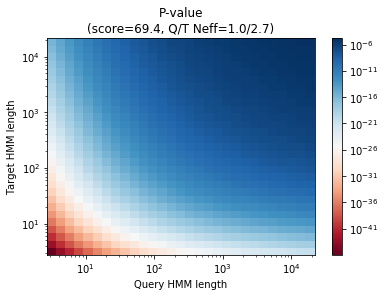

In [8]:
fig, ax = plt.subplots()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
sc = math.floor(h.score * 10) / 10
ax.set_title('P-value\n(score=' + str(sc) + ', Q/T Neff=' + str(h.q_Neff) + '/' + str(h.t_Neff)+ ')')
ax.set_xlabel('Query HMM length')
ax.set_ylabel('Target HMM length')

p = ax.pcolor(X, Y, Pval, cmap=cm.RdBu, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
# FIXME ax.plot(x=[hit.q_L], y=[hit.t_L], marker='Hit', linestyle='-', color='k')
cb = fig.colorbar(p)


### Probability as a function of query / target lengths

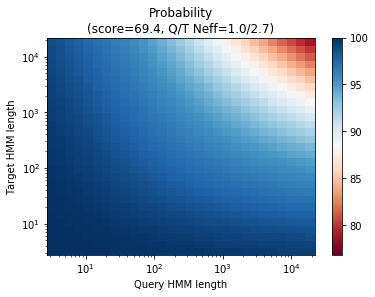

In [9]:
fig, ax = plt.subplots()
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_title('Probability\n(score=' + str(sc) + ', Q/T Neff=' + str(h.q_Neff) + '/' + str(h.t_Neff)+ ')')
ax.set_xlabel('Query HMM length')
ax.set_ylabel('Target HMM length')

p = ax.pcolor(X, Y, Prob, cmap=cm.RdBu, vmin=Prob.min(), vmax=100)
cb = fig.colorbar(p)

In [10]:
q_neff = np.linspace(1, 20, 20)
t_neff = np.linspace(1, 20, 20)
X,Y = np.meshgrid(q_neff, t_neff)

def testNeff(Z, func):
    for i, x in enumerate(q_neff):
        for j, y in enumerate(t_neff):
            Z[i, j] = func(x, y)

In [13]:
h = cp.copy(hit)

Pval = X.copy()
testNeff(Pval, getPvalueNeff)

Prob = X.copy()
testNeff(Prob, getProbabNeff)

### P-value as a function of query / target diversities

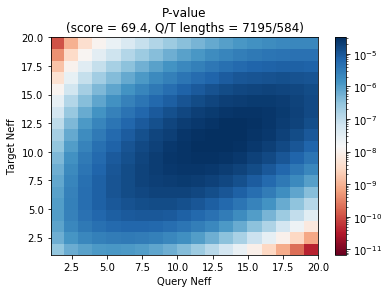

In [14]:
fig, ax = plt.subplots()
ax.set_title('P-value\n(score = ' + str(sc) + ', Q/T lengths = ' + str(h.q_L) + '/' + str(h.t_L) + ')')
ax.set_xlabel('Query Neff')
ax.set_ylabel('Target Neff')

p = ax.pcolor(X, Y, Pval, cmap=cm.RdBu, norm=LogNorm(vmin=Pval.min(), vmax=Pval.max()))
cb = fig.colorbar(p)

### Probability as a function of query / target diversities

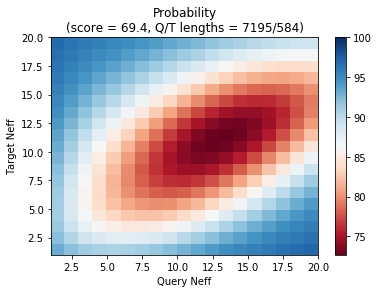

In [15]:
fig, ax = plt.subplots()
ax.set_title('Probability\n(score = ' + str(sc) + ', Q/T lengths = ' + str(h.q_L) + '/' + str(h.t_L) + ')')
ax.set_xlabel('Query Neff')
ax.set_ylabel('Target Neff')

p = ax.pcolor(X, Y, Prob, cmap=cm.RdBu, vmin=Prob.min(), vmax=100)
cb = fig.colorbar(p)

In [57]:
q_len_log = np.linspace(1, 10, 30)
X = np.exp(q_len_log)

h = cp.copy(hit)

def resetHit(norm):
    global h
    h = cp.copy(hit)
    if norm:
        h.t_L = h.q_L = 100
        h.q_Neff = h.t_Neff = 1

def getEvalueQLen(q_len):
    h.q_L = q_len
    CalculatePvalues(h)
    return h.Pval

def getEvalueTLen(t_len):
    h.t_L = t_len
    CalculatePvalues(h)
    return h.Pval

def testLengths(Z, func, norm):
    for i, logx in enumerate(q_len_log):
        x = math.exp(logx)
        resetHit(norm)
        Z[i] = func(x)

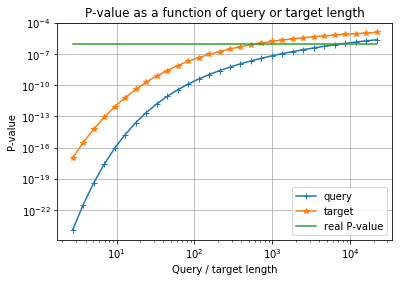

In [64]:
fig, ax = plt.subplots()

QPval = X.copy()
testLengths(QPval, getEvalueQLen, False)

TPval = X.copy()
testLengths(TPval, getEvalueTLen, False)

ax.loglog(X, QPval, '+-', label='query')
ax.loglog(X, TPval, '*-', label='target')
ax.plot(X, [hit.Pval] * len(X), '-', label='real P-value')
ax.legend()
ax.grid(True)
ax.set_title('P-value as a function of query or target length')
ax.set_xlabel('Query / target length')
ax.set_ylabel('P-value');

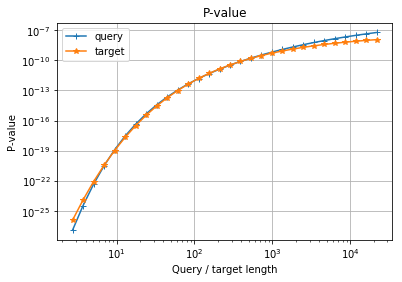

In [65]:
fig, ax = plt.subplots()

QPval = X.copy()
testLengths(QPval, getEvalueQLen, True)

TPval = X.copy()
testLengths(TPval, getEvalueTLen, True)

ax.loglog(X, QPval, '+-', label='query')
ax.loglog(X, TPval, '*-', label='target')

ax.legend()
ax.grid(True)
ax.set_title('P-value')
ax.set_xlabel('Query / target length')
ax.set_ylabel('P-value');